In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
# load weekly perp_margin_vol
weekly_perp_vol = pl.read_csv("data/weekly_perp_vol.csv")

In [3]:
# convert timestamp to datetime
weekly_perp_vol = weekly_perp_vol.with_columns(
    pl.col("timestamp").str.to_date(format='%Y-%m-%d')
)

In [4]:
weekly_perp_vol = weekly_perp_vol.filter(
    (pl.col("timestamp") >= pl.date(2023,4,1))
)

### Plot Weekly Perp Dex Volume

In [5]:
pivot_weekly_perp_vol = weekly_perp_vol.pivot(
    index="timestamp",
    columns="protocol",
    values="weekly_vol",
    # aggregate_function=pl.col('price').mean()
)

/tmp/ipykernel_290085/2301684709.py:1: DeprecationWarning: In a future version of polars, the default `aggregate_function` will change from `'first'` to `None`. Please pass `'first'` to keep the current behaviour, or `None` to accept the new one.
  pivot_weekly_perp_vol = weekly_perp_vol.pivot(


In [6]:
pivot_weekly_perp_vol

timestamp,GMX,GNS,KWENTA,LEVEL,MUX,PERP,VERTEX
date,f64,f64,f64,f64,f64,f64,f64
2023-04-03,2146002804.6110072,640707828.258858,198754108.1684233,1398476139.1705084,289953605.1236437,221499966.4437374,null
2023-04-10,2308617465.502606,809754123.4618278,832223915.5440781,1894958779.5983407,435372844.47140694,233959850.32883778,null
2023-04-17,1633830566.9505024,665036834.4749379,609633805.5020286,1158380813.1224465,444741000.12080276,250029410.40824816,null
2023-04-24,1724181904.738169,654761943.2942421,713306642.7820381,652659633.0304015,290327397.4115523,256688735.9809675,81000885.74519557
2023-05-01,1387840372.5412006,592816493.9349751,1114677949.775283,617757887.0938053,394700206.20803094,253071451.06026465,141655207.95353246
2023-05-08,1205529302.3205414,823675764.354748,1149268017.5292084,466189902.0344189,471703302.08410615,248474605.69517535,140249291.8240417
2023-05-15,523085667.733175,340892668.62851155,1278728108.1219852,313649520.07868785,165923796.1480706,237652141.75908163,199655109.3996759
2023-05-22,630938533.5312079,345439660.29751706,1125507006.2746847,755485397.9438285,149135780.5626102,239815533.3257535,225627589.27153584
2023-05-29,809199063.9418124,556851758.3450288,245657684.9900978,545235195.2389659,258753861.10440245,231561344.8349914,208447585.53438696


In [ ]:
pd_chart = pivot_weekly_perp_vol.to_pandas()

In [ ]:
# fill nans with 0
pd_chart = pd_chart.fillna(0)

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

In [ ]:
# set timestamp as index
pd_chart = pd_chart.set_index('timestamp')

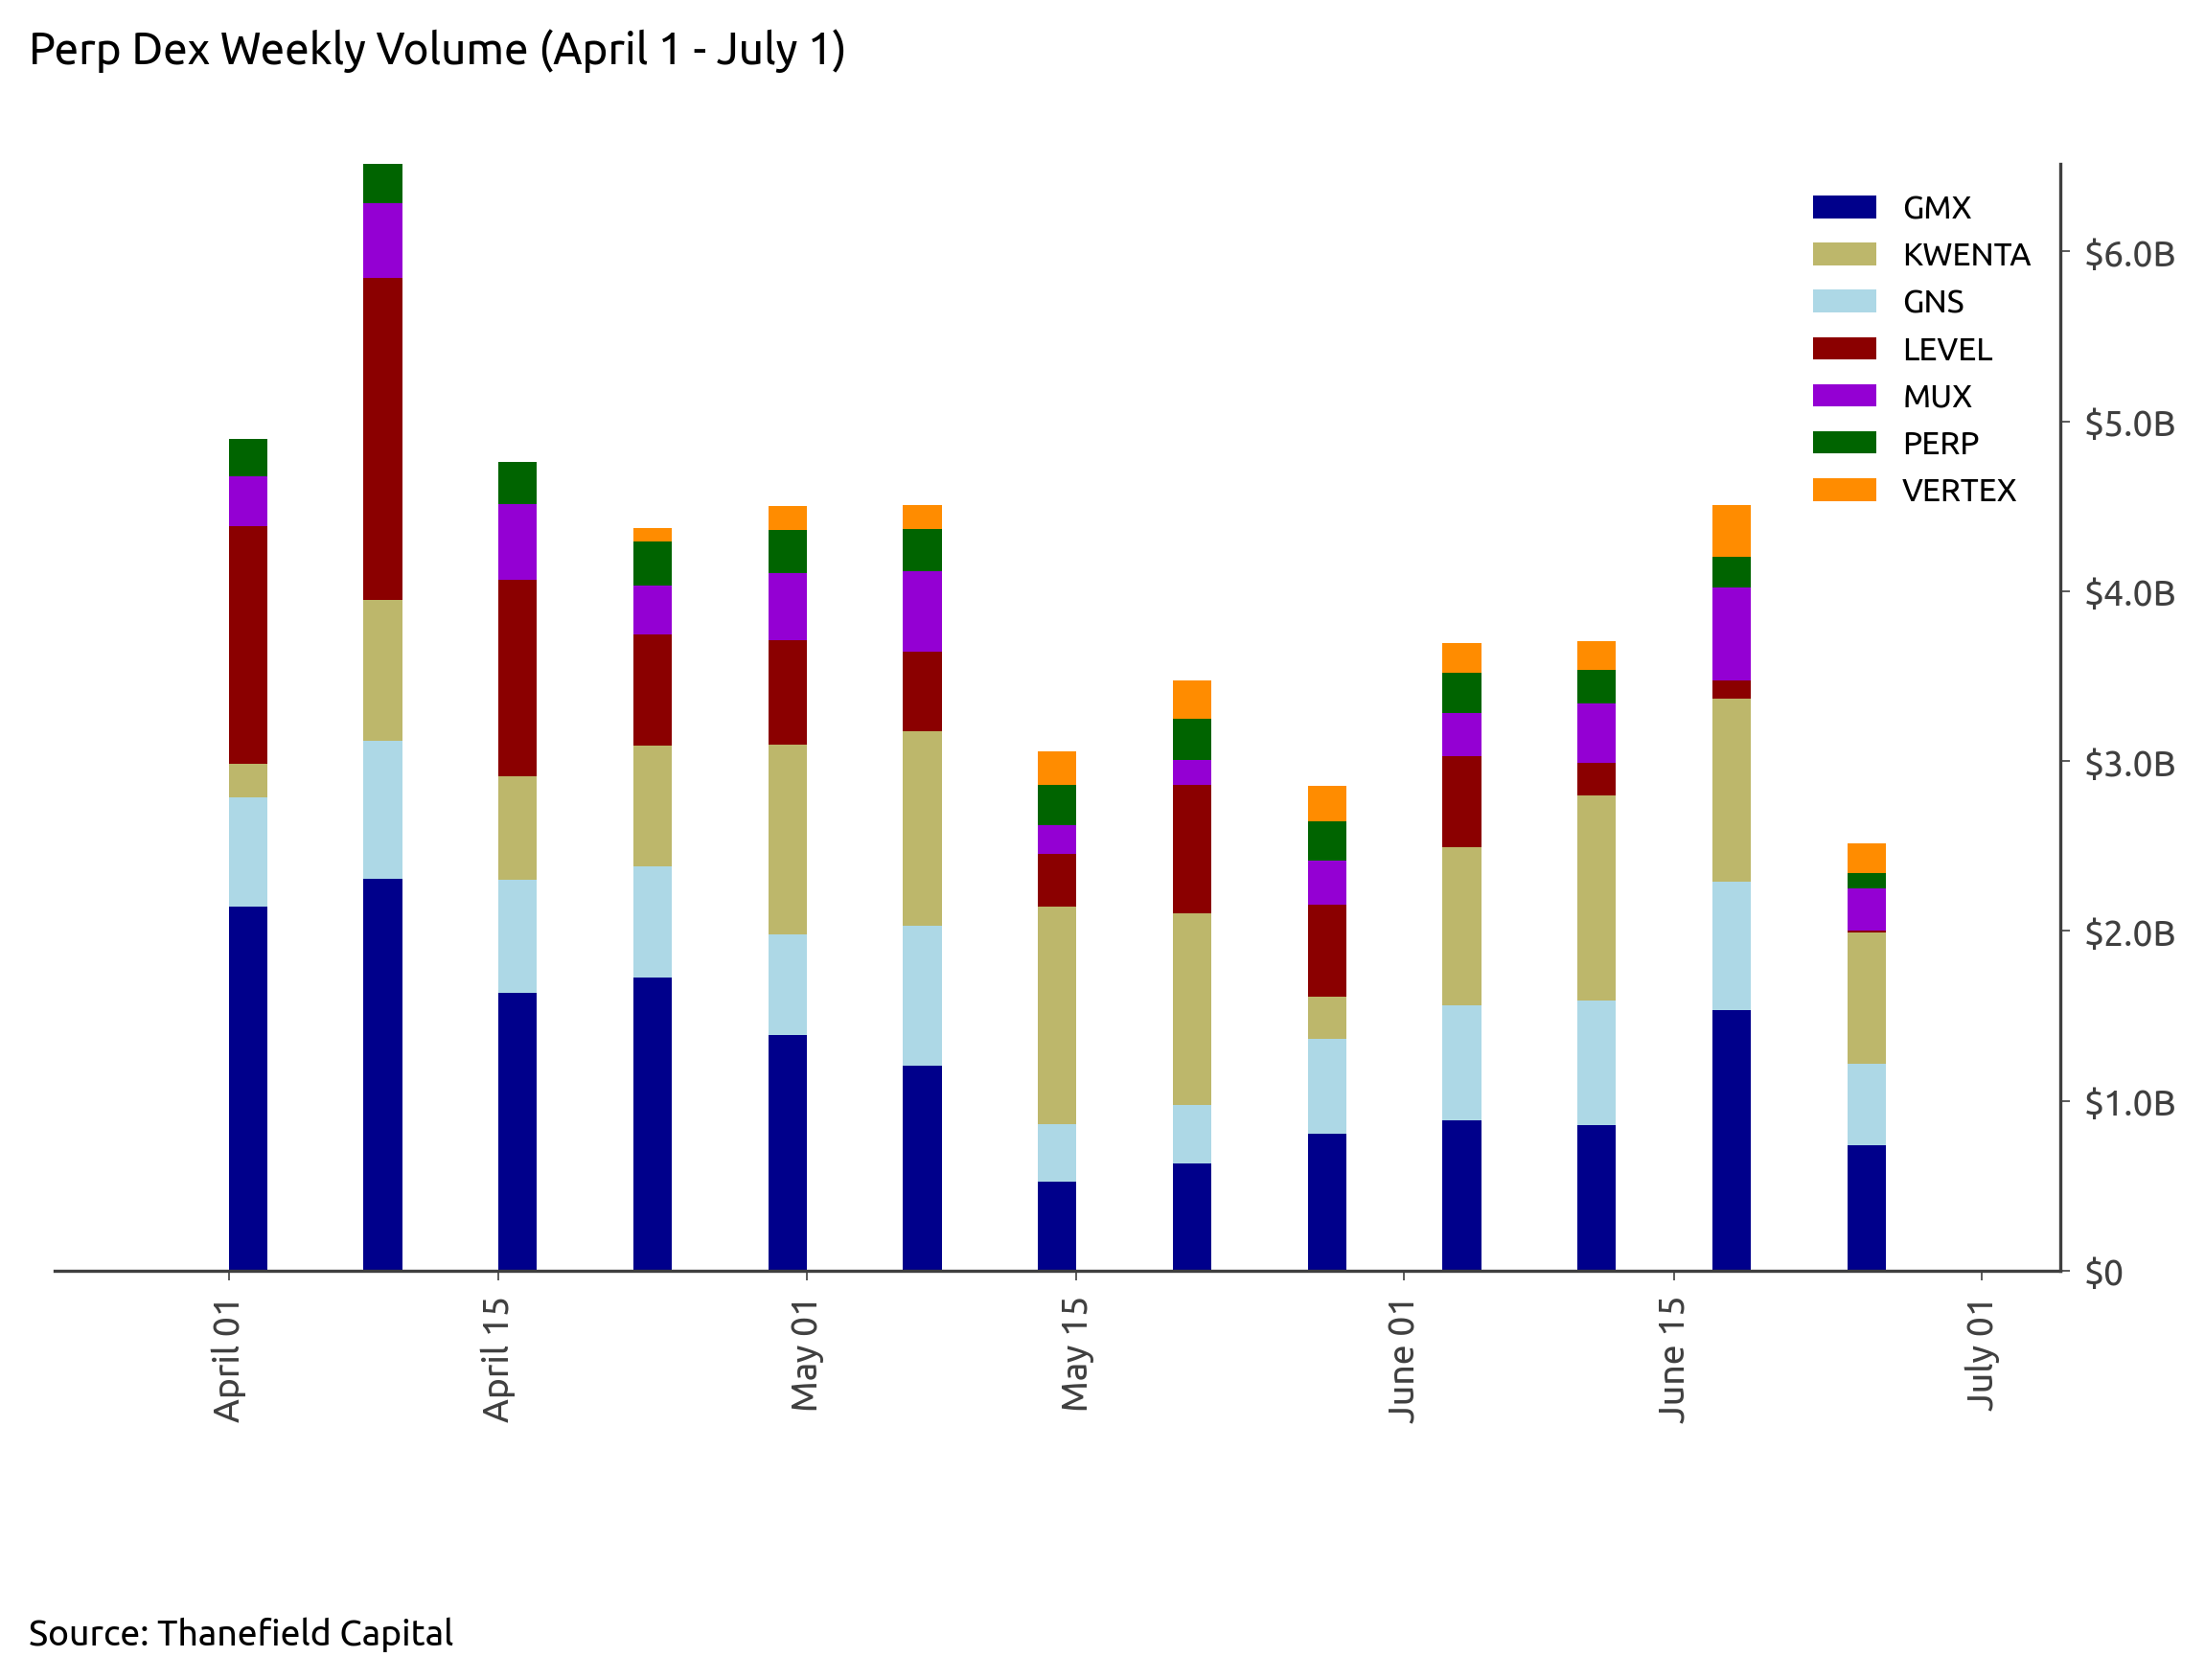

In [ ]:
# Create the bar chart
fig, ax = tc.chart('Perp Dex Weekly Volume (April 1 - July 1)', dates=False)

# Stacked bar chart
ax.bar(pd_chart.index, pd_chart['GMX'], color='darkblue', label='GMX', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['KWENTA'], bottom=pd_chart['GMX']+pd_chart['GNS'], color='darkkhaki', label='KWENTA', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['GNS'], bottom=pd_chart['GMX'], color='lightblue', label='GNS', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['LEVEL'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA'], color='darkred', label='LEVEL', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['MUX'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA']+pd_chart['LEVEL'], color='darkviolet', label='MUX', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['PERP'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA']+pd_chart['LEVEL']+pd_chart['MUX'], color='darkgreen', label='PERP', align='edge', width=-2)
ax.bar(pd_chart.index, pd_chart['VERTEX'], bottom=pd_chart['GMX']+pd_chart['GNS']+pd_chart['KWENTA']+pd_chart['LEVEL']+pd_chart['MUX']+pd_chart['PERP'], color='darkorange', label='VERTEX', align='edge', width=-2)

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))


# formatting
tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
# plt.tight_layout()
plt.xticks(rotation=90)

# save chart
tc.save('charts/perp_dex_weekly_vol.png')